In [2]:
from PIL import Image   ##python image library
import os, glob, numpy as np  ## os,glob 운영체제 관리 numpy 수학적 표현
from sklearn.model_selection import train_test_split  ##함수 전체 데이터셋을 받아 랜덤하게 훈련테스트 시키는 데이터 셋 분류

caltech_dir = "./catdateset/train"
categories = ["Bombay", "Persian", "Russianblue", "Siberia","Sphynx","Sham"]  ##카테고리 설정
nb_classes = len(categories)

image_w = 64   ##이미지 표현
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))   ##파일을 JPG->RGB
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)   
        y.append(label)

        if i % 700 == 0:   ##???
            print(cat, " : ", f)

X = np.array(X) ##배열 
y = np.array(y)



X_train, X_test, y_train, y_test = train_test_split(X, y)   ##그래프 표현을 위한 설정
xy = (X_train, X_test, y_train, y_test)
np.save("./numpy_data/m_image_data.npy", xy)  

print("ok", len(y))


Bombay  파일 길이 :  499
Bombay  :  ./catdateset/train/Bombay\bombay001.jpg
Persian  파일 길이 :  526
Persian  :  ./catdateset/train/Persian\persian (1).jpg
Russianblue  파일 길이 :  2262
Russianblue  :  ./catdateset/train/Russianblue\Rusianblue(1).jpg
Russianblue  :  ./catdateset/train/Russianblue\Rusianblue(1629).jpg
Russianblue  :  ./catdateset/train/Russianblue\Rusianblue(2259).jpg
Russianblue  :  ./catdateset/train/Russianblue\Rusianblue(853).jpg
Siberia  파일 길이 :  1562
Siberia  :  ./catdateset/train/Siberia\Siberia (100).jpg
Siberia  :  ./catdateset/train/Siberia\Siberia (216).jpg
Siberia  :  ./catdateset/train/Siberia\Siberia (852).jpg
Sphynx  파일 길이 :  132
Sphynx  :  ./catdateset/train/Sphynx\Sphynx (1).jpg
Sham  파일 길이 :  200
Sham  :  ./catdateset/train/Sham\siam (1).jpg
ok 5181


이제 numpy 데이터를 불러온다. 

In [3]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K   

import tensorflow as tf   #GPU 구현에 있어서 메모리를 절약해서 사용하기 위한 코드
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

X_train, X_test, y_train, y_test = np.load('./numpy_data/m_image_data.npy',allow_pickle=True)
print(X_train.shape)
print(y_train[:10])
print(X_train.shape)

Using TensorFlow backend.


(3885, 64, 64, 3)
[[0 0 0 0 0 1]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]]
(3885, 64, 64, 3)


In [4]:
categories = ["Bombay", "Persian", "Russianblue", "Siberia","Sphynx","Sham"]  ##카데고리 설정
nb_classes = len(categories)

#일반화 ##정규화를 통해서 폭의 크기를 줄여줍니다.
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [5]:
with K.tf_ops.device('/device:GPU:0'): #CNN 환경 구현 선형->비선형(합성 곱)->폴링 계층// #GPU:O  
    model = Sequential()   ##선형계층
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))##비선형
    model.add(MaxPooling2D(pool_size=(2,2)))## 폴링 계층
    model.add(Dropout(0.2)) ##에러율 감소를 위해 사용하는  훈련 함수   Dropout->1이 되어야한다.
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu')) ##64개
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3,3), padding="same", activation='relu'))  ##128개
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(256, (3,3), padding="same", activation='relu'))  ##256개
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())  ##다차원배열을  1차원으로 변경
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(nb_classes, activation='softmax')) ##soft max->0부터1사이의 출력값은 실수이며 출력의 총합을 1로 표현 확률을 표현할때 사용
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) ##optimization ->딥러닝에서 학습속도를 빠르고 안정적이게 하는것  
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True) ##keras 모델 체크포인트 save_best_only->정확도의 최고값을 갱신할때만 사용
    early_stopping = EarlyStopping(monitor='val_loss', patience=6) ##학습 종료 patience 성능이 증가하지 않는 epoch를 몇번이나 허용할 것인가 정의
    ##최적의 데이터를 학습하면 더이상 학습을 하지 않는다
    

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)      

In [7]:

#데이터셋이 적어서 validation을 그냥 test 데이터로 했습니다. 
#데이터셋이 충분하시면 이렇게 하시지 마시고 validation_split=0.2 이렇게 하셔서 테스트 셋으로 나누시길 권장합니다.
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])
##batch_size=numpy 데이터를 전달하면 모델을 작은 배치로 나누고 훈련과정에서 배치늘 순회 배치의 크기를 지정 
##epochs=전체 입력데이터를 한번 순회하는 것
##모델의 프로토타입을 만들때 검증데이터에서 간단한 선능을 모니터링

Train on 3885 samples, validate on 1296 samples
Epoch 1/50
3885/3885 [==============================] - 67s 17ms/step - loss: 1.3978 - accuracy: 0.4358 - val_loss: 1.1180 - val_accuracy: 0.5509

Epoch 00001: val_loss improved from inf to 1.11797, saving model to ./model/multi_img_classification.model
Epoch 2/50
3885/3885 [==============================] - 58s 15ms/step - loss: 0.9958 - accuracy: 0.6082 - val_loss: 0.9056 - val_accuracy: 0.6327

Epoch 00002: val_loss improved from 1.11797 to 0.90560, saving model to ./model/multi_img_classification.model
Epoch 3/50
3885/3885 [==============================] - 58s 15ms/step - loss: 0.8162 - accuracy: 0.6947 - val_loss: 0.7866 - val_accuracy: 0.7369

Epoch 00003: val_loss improved from 0.90560 to 0.78664, saving model to ./model/multi_img_classification.model
Epoch 4/50
3885/3885 [==============================] - 58s 15ms/step - loss: 0.6935 - accuracy: 0.7426 - val_loss: 0.7300 - val_accuracy: 0.7369

Epoch 00004: val_loss improved from

In [8]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

1296/1296 [==============================] - 5s 4ms/step
정확도 : 0.9097


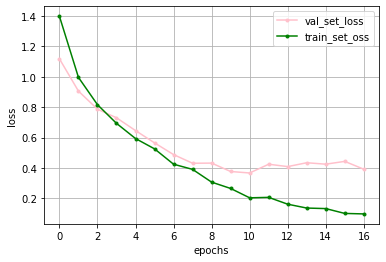

In [9]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='pink', label='val_set_loss')  ##데이터
plt.plot(x_len, y_loss, marker='.', c='green', label='train_set_oss')##훈련
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

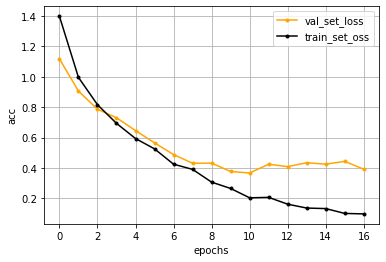

In [10]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='orange', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='black', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('acc')
plt.grid()
plt.show()

In [11]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "./catdateset/train/image_others"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "Bombay"
    elif pre_ans == 1: pre_ans_str = "Persian"
    elif pre_ans == 2: pre_ans_str = "Russianblue"
    elif pre_ans == 3: pre_ans_str = "Siberia"
    elif pre_ans == 4: pre_ans_str = "Sphynx"
    else: pre_ans_str = "Sham"
    if i[0] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[3] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[4] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[5] >= 0.8 : print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")                      
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.


[1.000 0.000 0.000 0.000 0.000 0.000]
0
해당 1.jpg이미지는 Bombay로 추정됩니다.
[0.000 0.000 0.000 0.000 0.000 1.000]
5
해당 2.jpg이미지는 Sham로 추정됩니다.
[0.000 1.000 0.000 0.000 0.000 0.000]
1
해당 3.jpg이미지는 Persian으로 추정됩니다.
[0.000 0.000 0.000 1.000 0.000 0.000]
3
해당 4.jpg이미지는 Siberia로 추정됩니다.
[0.000 0.000 0.000 0.000 1.000 0.000]
4
해당 xcv.jpg이미지는 Sphynx로 추정됩니다.
[0.000 0.000 0.000 1.000 0.000 0.000]
3
해당 다운로213드.jpg이미지는 Siberia로 추정됩니다.
